## Import Library

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Prepare Dataset
Dataset : [Stanford Dogs](https://www.cs.toronto.edu/~kriz/cifar.html)

In [2]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
num_classes = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE

def scale(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.float32)
  image /= 255
  return image, label

def augment(image, label):
  image, label = scale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE+16, IMG_SIZE+16)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=03)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_saturation(image, .5, 2)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [3]:
def dog_dataset(batch_size):
  global num_classes
  num_classes = 10
  datasets, info = tfds.load(name='stanford_dogs', with_info=True, as_supervised=True)
  train, validation = datasets['train'], datasets['test']
  train_dataset = train.map(augment, num_parallel_calls=AUTOTUNE).shuffle(1000).repeat().batch(batch_size).prefetch(AUTOTUNE)
  valid_dataset = validation.map(scale, num_parallel_calls=AUTOTUNE).shuffle(1000).repeat().batch(batch_size).prefetch(AUTOTUNE)

  return train_dataset, valid_dataset

In [4]:
!mkdir -p result

result_df = None

In [5]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(1000*(time.time() - self.epoch_time_start))

def log_training_result(history, time_callback, dataset_name):
  global result_df
  execute_epochs = len(history['loss'])

  history['dataset'] = dataset_name
  history['time per step(ms/step)'] = time_callback.times
  history['epoch'] = range(1, execute_epochs+1)
  df = pd.DataFrame(history, columns=['dataset', 'epoch', 'time per step(ms/step)', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])
  if result_df is None:
    result_df = df
  else:
    result_df = result_df.append(df, ignore_index=True)
  print(result_df.tail())

## Train model

In [6]:
# Create the base model from the pre-trained model NASNetMobile
base_model = tf.keras.applications.NASNetMobile(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

19996672/19993432 [==============================] - 0s 0us/step


In [7]:
early_stop = tf.keras.callbacks.EarlyStopping('val_loss', patience=5)
time_callback = TimeHistory()

batch_size = 64

# Load dataset
train_dataset, valid_dataset = dog_dataset(batch_size)

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteN7526X/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteN7526X/stanford_dogs-test.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [8]:
# Create model
num_classes = 120
model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(num_classes)
  ])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               126840    
Total params: 4,396,556
Trainable params: 126,840
Non-trainable params: 4,269,716
_________________________________________________________________


In [9]:
# Train model
num_epochs = 50

history = model.fit(train_dataset,
                    epochs=num_epochs,
                    steps_per_epoch=50,
                    validation_data=valid_dataset,
                    validation_steps=30,
                    callbacks=[time_callback, early_stop])
log_training_result(history.history, time_callback, "stanford_dogs")

Epoch 1/50
50/50 [==============================] - 16s 320ms/step - loss: 2.7215 - accuracy: 0.5016 - val_loss: 1.0819 - val_accuracy: 0.7974
Epoch 2/50
50/50 [==============================] - 13s 266ms/step - loss: 0.8182 - accuracy: 0.8091 - val_loss: 0.6494 - val_accuracy: 0.8333
Epoch 3/50
50/50 [==============================] - 13s 264ms/step - loss: 0.6814 - accuracy: 0.8000 - val_loss: 0.6244 - val_accuracy: 0.8271
Epoch 4/50
50/50 [==============================] - 14s 284ms/step - loss: 0.5548 - accuracy: 0.8303 - val_loss: 0.5626 - val_accuracy: 0.8318
Epoch 5/50
50/50 [==============================] - 15s 294ms/step - loss: 0.5254 - accuracy: 0.8381 - val_loss: 0.5862 - val_accuracy: 0.8182
Epoch 6/50
50/50 [==============================] - 14s 275ms/step - loss: 0.5052 - accuracy: 0.8406 - val_loss: 0.5971 - val_accuracy: 0.8260
Epoch 7/50
50/50 [==============================] - 14s 276ms/step - loss: 0.5039 - accuracy: 0.8484 - val_loss: 0.5619 - val_accuracy: 0.8307

## Training result

In [10]:
times = time_callback.times 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 0, 'Epoch')

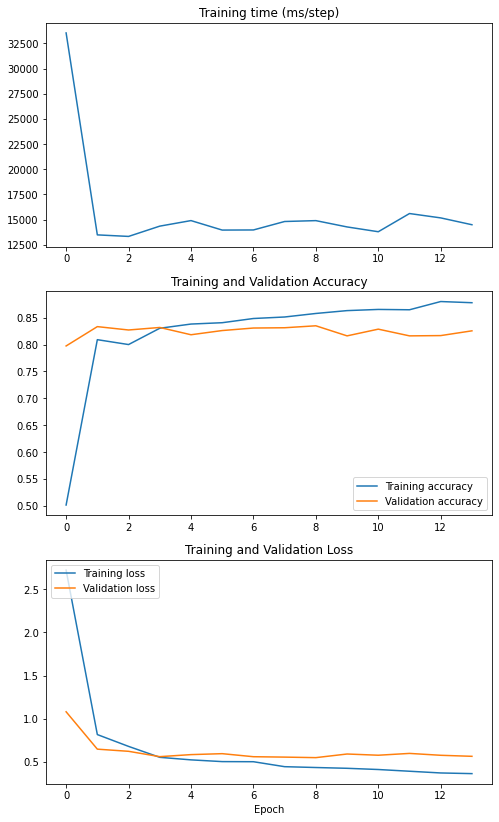

In [11]:
# Display training result
plt.figure(figsize=(8, 14))

plt.subplot(3, 1, 1)
plt.plot(times)
plt.title("Training time (ms/step)")

plt.subplot(3, 1, 2)
plt.plot(acc, label="Training accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 3)
plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.xlabel("Epoch")